# Passing the Pileup events through the L0-DTree
Having trained a L0 model to perform a preliminary cut on data, let now see what kind of events survive among the Ar39 Pileups.

To this aim, we load the Pileup datasets, process the required features and then pass them through the model.

In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 35})

# Model pruning
The trained model is redundant and can be pruned without reducing its effectiveness. The original tree uses the following features:
- PEDetected_inner
- MeanNPEActive_inner
- PEDetected_outer
- NActiveSlices_outer
- MeanNPEActive_outer
- SpatialRange_outer
- PEDetected_tot

The pruned tree uses the following features:
- PEDetected_inner
- PEDetected_outer
- NActiveSlices_outer

Its decision logic can be expressed by a simple function, reported below.

# Load Ar39-Pileup Datasets

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=1000):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files (over {}) wt prefix:\n{}".format(len(files[:max_files]), len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "Ar39_07_09_2020", "Ar39_Snapshots")
fileinprefix = "Snapshot{}Ar39*.csv"

ar39_dfs = []
ar39_dfs_names = []
for nPileups in range(1, 8):    # 2, 3, 4, 5, 6, 7
    df_ar39 = load_dataframe_from_files(dirin, fileinprefix.format(nPileups))
    df_ar39 = df_ar39[df_ar39.columns[:-1]]
    ar39_dfs.append(df_ar39)
    ar39_dfs_names.append("{} Ar39".format(nPileups))
del df_ar39

[Info] Loading 100 files (over 100) wt prefix:
Snapshot1Ar39*.csv
...................................................................................................
[Info] Loading 100 files (over 100) wt prefix:
Snapshot2Ar39*.csv
...................................................................................................
[Info] Loading 100 files (over 100) wt prefix:
Snapshot3Ar39*.csv
...................................................................................................
[Info] Loading 100 files (over 100) wt prefix:
Snapshot4Ar39*.csv
...................................................................................................
[Info] Loading 100 files (over 100) wt prefix:
Snapshot5Ar39*.csv
...................................................................................................
[Info] Loading 100 files (over 100) wt prefix:
Snapshot6Ar39*.csv
...................................................................................................
[Inf

Trained Model - Before Pruning


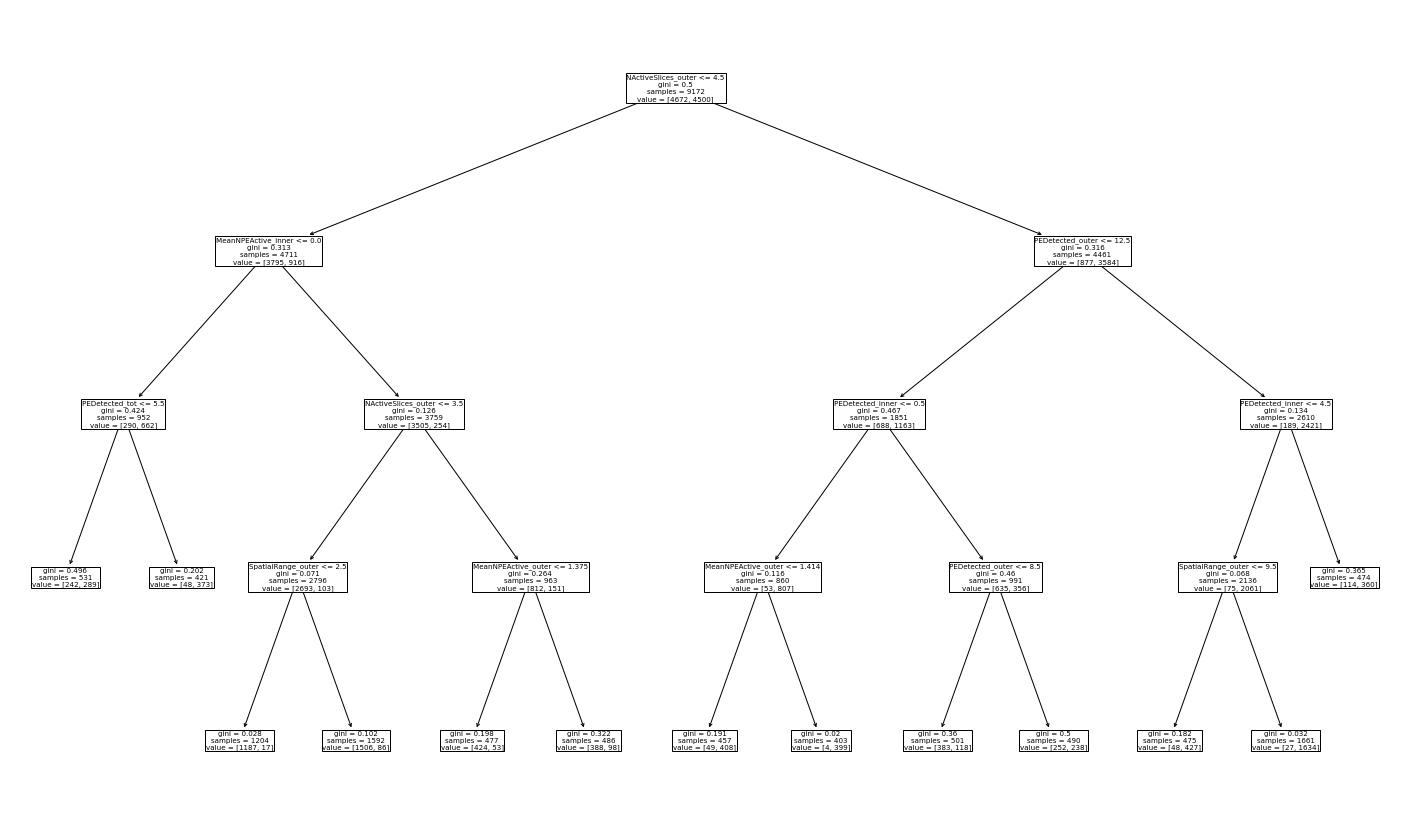

In [4]:
from joblib import dump, load
from sklearn import tree

my_features = ["PEDetected_inner", "NActiveSlices_inner", "MeanNPEActive_inner", "SpatialRange_inner", 
               "PEDetected_outer", "NActiveSlices_outer", "MeanNPEActive_outer", "SpatialRange_outer", 
               "PEDetected_tot", "NActiveSlices_tot"]

clf = load("../models/dtree_trained_npe5_60_09lug2020.joblib")

print("Trained Model - Before Pruning")
tree.plot_tree(clf, feature_names=my_features)
plt.show()

# Create features

In [5]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def mean_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.mean(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def std_npe(row):
    return np.std(row.to_numpy())

def std_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.std(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

def compute_features(row):
    rownp = row.to_numpy()
    return [np.sum(rownp),                        # NPE
            np.nonzero(rownp)[0].shape[0],        # NActiveSlices
            np.mean(rownp),                       # Mean NPE
            np.std(rownp),                        # Std NPE
            np.nonzero(rownp)[0][-1] - np.nonzero(rownp)[0][0] + 1,    # Range
            np.var(np.repeat(np.argwhere(rownp>0), rownp[rownp>0])),   # Var
            np.std(np.repeat(np.argwhere(rownp>0), rownp[rownp>0]))]   # Var   


In [6]:
import time
n_inner_slices, n_outer_slices = 12, 20
ar39_feat_dfs = []
for ar39_df, name in zip(ar39_dfs, ar39_dfs_names):
    init = time.time()
    print("[Info] Creating features for Dataset: {} ({} entries) ".format(name, len(ar39_df)))
    ar39_feat = pd.DataFrame()
    ar39_feat["PEDetected_inner"] = ar39_df.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
    ar39_feat["PEDetected_outer"] = ar39_df.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
    ar39_feat["NActiveSlices_outer"] = ar39_df.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
    ar39_feat_dfs.append(ar39_feat)
    print("\tDone. Time: {:.3f} sec".format(time.time() - init))

[Info] Creating features for Dataset: 1 Ar39 (6308949 entries) 
	Done. Time: 159.009 sec
[Info] Creating features for Dataset: 2 Ar39 (3154449 entries) 
	Done. Time: 77.461 sec
[Info] Creating features for Dataset: 3 Ar39 (2102949 entries) 
	Done. Time: 52.021 sec
[Info] Creating features for Dataset: 4 Ar39 (1577196 entries) 
	Done. Time: 39.302 sec
[Info] Creating features for Dataset: 5 Ar39 (1261754 entries) 
	Done. Time: 31.698 sec
[Info] Creating features for Dataset: 6 Ar39 (1051448 entries) 
	Done. Time: 26.116 sec
[Info] Creating features for Dataset: 7 Ar39 (901235 entries) 
	Done. Time: 22.324 sec


# Inference wt DTree

In [7]:
PEDetected_inner, PEDetected_outer, NActiveSlices_outer = 0, 1, 2    # to call the position
target_ar, target_mu = 0, 1
def l0_dtree_func(row):
    # `row` is a line in the format PEDetected_inner, PEDetected_outer, NActiveSlices_outer
    row = row.to_numpy()
    if (row[PEDetected_inner]+row[PEDetected_outer]<5):
        return target_ar
    if(row[NActiveSlices_outer] <= 4.5):   #NActiveSlice_outer <= 4.5
        if(row[PEDetected_inner] <= 0.5):
            return target_mu
    elif(row[PEDetected_outer] > 12.5):    #NActiveSlice_outer > 4.5
            return target_mu
    elif(row[PEDetected_inner] <= 0):       #NActiveSlice_outer > 4.5 & PEDetected_outer<=12.5
            return target_mu
    return target_ar

In [8]:
import time
n_inner_slices, n_outer_slices = 12, 20
for ar39_df, ar39_feat_df, name in zip(ar39_dfs, ar39_feat_dfs, ar39_dfs_names):
    init = time.time()
    print("[Info] Inference on Dataset: {} ({} entries) ".format(name, len(ar39_feat_df)))
    ar39_df["y_dtree_pred"] = ar39_feat_df.apply(lambda row: l0_dtree_func(row), axis=1)
    print("\tDone. Time: {:.3f} sec".format(time.time() - init))

[Info] Inference on Dataset: 1 Ar39 (6308949 entries) 
	Done. Time: 40.987 sec
[Info] Inference on Dataset: 2 Ar39 (3154449 entries) 
	Done. Time: 26.660 sec
[Info] Inference on Dataset: 3 Ar39 (2102949 entries) 
	Done. Time: 20.490 sec
[Info] Inference on Dataset: 4 Ar39 (1577196 entries) 
	Done. Time: 15.834 sec
[Info] Inference on Dataset: 5 Ar39 (1261754 entries) 
	Done. Time: 12.587 sec
[Info] Inference on Dataset: 6 Ar39 (1051448 entries) 
	Done. Time: 10.338 sec
[Info] Inference on Dataset: 7 Ar39 (901235 entries) 
	Done. Time: 8.921 sec


[Info] Dataset: 1 Ar39, FPR: 0.028126871845056918
[Info] Dataset: 2 Ar39, FPR: 0.21759204222353887
[Info] Dataset: 3 Ar39, FPR: 0.39855888088584174
[Info] Dataset: 4 Ar39, FPR: 0.5169477984980941
[Info] Dataset: 5 Ar39, FPR: 0.6432688146817842
[Info] Dataset: 6 Ar39, FPR: 0.7805673699507727
[Info] Dataset: 7 Ar39, FPR: 0.8912115042136624


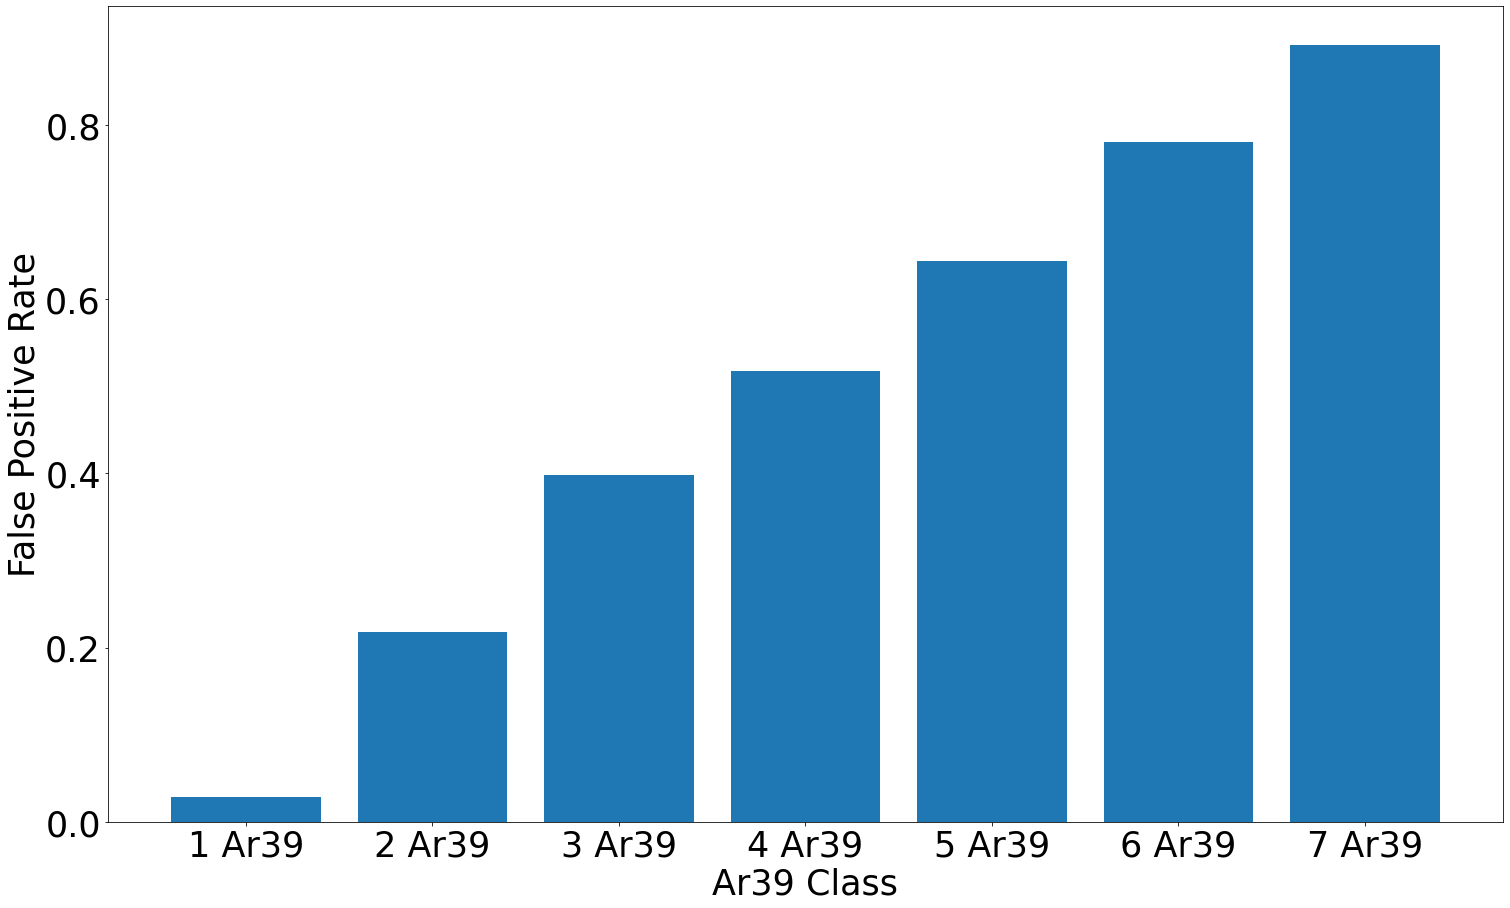

In [10]:
fpr_dfs_dt = []
for ar39_df, ar39_feat, name in zip(ar39_dfs, ar39_feat_dfs, ar39_dfs_names):
    fpr = len(ar39_df[ar39_df.y_dtree_pred==1])/len(ar39_df)
    print("[Info] Dataset: {}, FPR: {}".format(name, fpr))
    fpr_dfs_dt.append(fpr)
#plt.title("False Positive Rate - Min PE Cut + DTree - Ar39 Classes")
plt.bar(np.arange(len(fpr_dfs_dt)), fpr_dfs_dt, tick_label=ar39_dfs_names)
plt.xlabel("Ar39 Class")
plt.ylabel("False Positive Rate")
plt.show()

# Inference with CNN Model

In [11]:
import tensorflow as tf

cnn_model = tf.keras.models.load_model("../mu_vs_pileups/models/model_20200721-121423/model.oncerepeat1.epoch04-valacc0.85019")

In [13]:
import time
n_inner_slices, n_outer_slices = 12, 20
for ar39_df, name in zip(ar39_dfs, ar39_dfs_names):
    init = time.time()
    print("[Info] Inference on Dataset: {} ({} entries) ".format(name, len(ar39_df)))
    ar39_np = ar39_df.iloc[:, 3:3+n_inner_slices+n_outer_slices].to_numpy()
    ar39_np = ar39_np.reshape((ar39_np.shape[0], ar39_np.shape[1], 1))
    ar39_df["y_cnn_pred"] = cnn_model.predict(ar39_np)
    print("\tDone. Time: {:.3f} sec".format(time.time() - init))

[Info] Inference on Dataset: 1 Ar39 (6308949 entries) 
	Done. Time: 185.273 sec
[Info] Inference on Dataset: 2 Ar39 (3154449 entries) 
	Done. Time: 91.501 sec
[Info] Inference on Dataset: 3 Ar39 (2102949 entries) 
	Done. Time: 55.865 sec
[Info] Inference on Dataset: 4 Ar39 (1577196 entries) 
	Done. Time: 40.762 sec
[Info] Inference on Dataset: 5 Ar39 (1261754 entries) 
	Done. Time: 33.671 sec
[Info] Inference on Dataset: 6 Ar39 (1051448 entries) 
	Done. Time: 28.292 sec
[Info] Inference on Dataset: 7 Ar39 (901235 entries) 
	Done. Time: 23.910 sec


[Info] Dataset: 1 Ar39, FPR: 0.5571116520358621
[Info] Dataset: 2 Ar39, FPR: 0.21450655883166916
[Info] Dataset: 3 Ar39, FPR: 0.11670801336599224
[Info] Dataset: 4 Ar39, FPR: 0.08235501484913733
[Info] Dataset: 5 Ar39, FPR: 0.06781432830805371
[Info] Dataset: 6 Ar39, FPR: 0.06176149462455585
[Info] Dataset: 7 Ar39, FPR: 0.061231532286251646


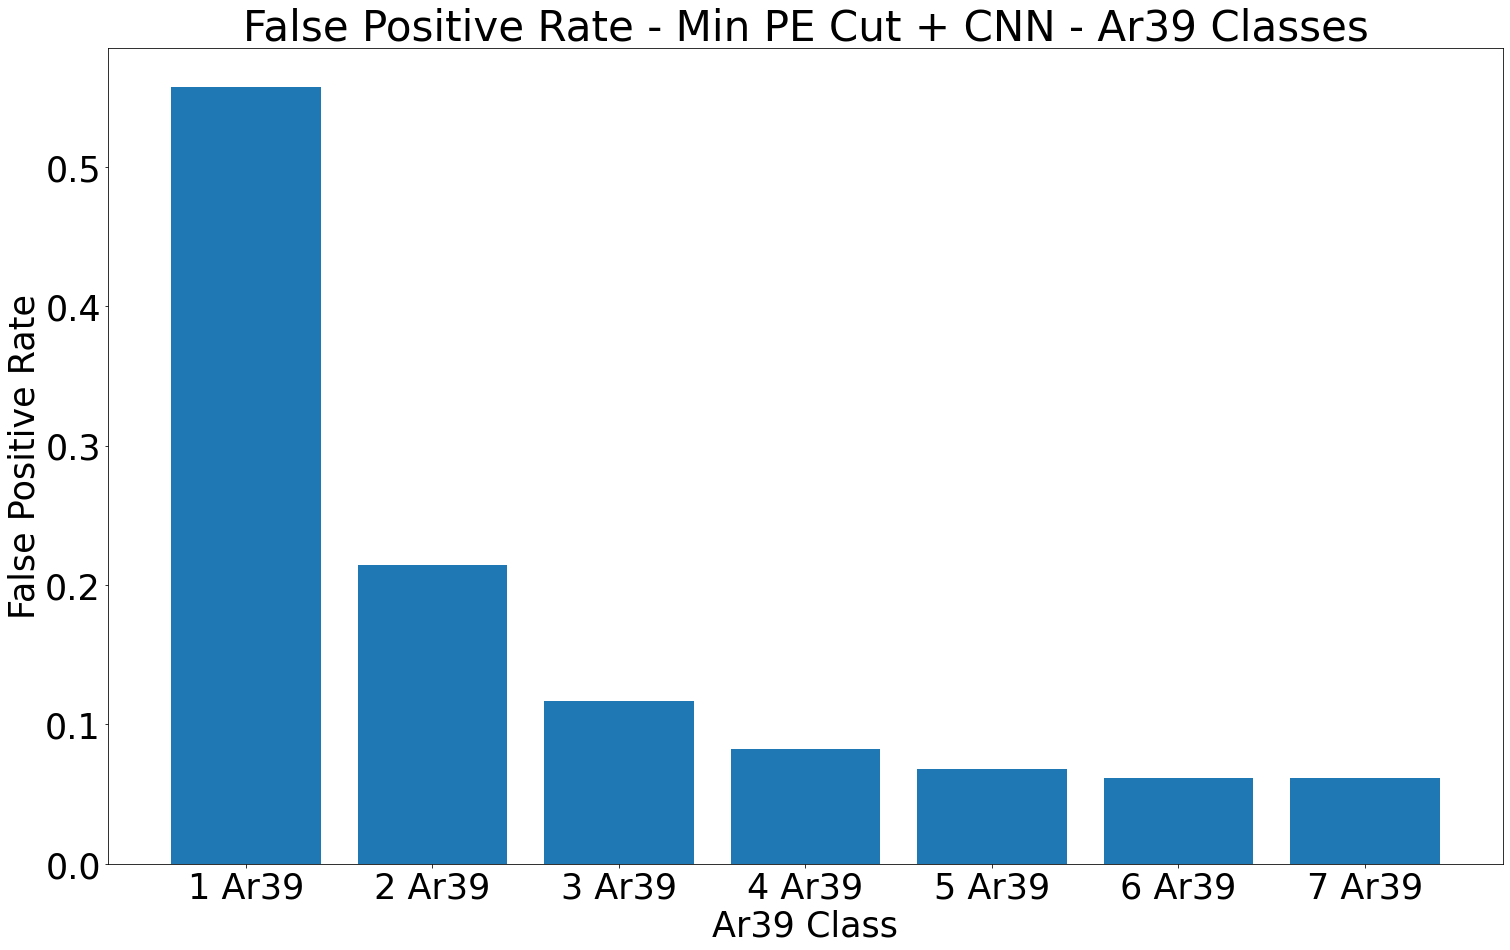

In [15]:
fpr_dfs_cnn = []
for ar39_df, name in zip(ar39_dfs, ar39_dfs_names):
    fpr = len(ar39_df[(ar39_df.y_cnn_pred>.50)])/len(ar39_df)
    print("[Info] Dataset: {}, FPR: {}".format(name, fpr))
    fpr_dfs_cnn.append(fpr)
plt.title("False Positive Rate - Min PE Cut + CNN - Ar39 Classes")
plt.bar(np.arange(len(fpr_dfs_cnn)), fpr_dfs_cnn, tick_label=ar39_dfs_names)
plt.xlabel("Ar39 Class")
plt.ylabel("False Positive Rate")
plt.show()

# What about muons?

In [16]:
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "Muons_07_09_2020", "Muons_Snapshots")
fileinprefix = "SnapshotMuon*.csv"

df_mu = load_dataframe_from_files(dirin, fileinprefix)
df_mu = df_mu[df_mu.columns[:-1]]

[Info] Loading 200 files (over 200) wt prefix:
SnapshotMuon*.csv
.......................................................................................................................................................................................................


In [17]:
len(df_mu[(df_mu.pedetected<5)])/len(df_mu)

0.15053694910933368

In [18]:
import time
init = time.time()
print("[Info] Creating features for Dataset: {} ({} entries) ".format("Muons", len(df_mu)))
mu_feat = pd.DataFrame()
mu_feat["PEDetected_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
mu_feat["PEDetected_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
mu_feat["NActiveSlices_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
print("\tDone. Time: {:.3f} sec".format(time.time() - init))

[Info] Creating features for Dataset: Muons (31381 entries) 
	Done. Time: 0.784 sec


In [19]:
init = time.time()
print("[Info] Inference on Dataset: {} ({} entries) ".format("Muons", len(mu_feat)))
df_mu["y_dtree_pred"] = mu_feat.apply(lambda row: l0_dtree_func(row), axis=1)
print("\tDone. Time: {:.3f} sec".format(time.time() - init))

[Info] Inference on Dataset: Muons (31381 entries) 
	Done. Time: 0.299 sec


In [20]:
import time
init = time.time()
print("[Info] Inference on Dataset: {} ({} entries) ".format("Muons", len(df_mu)))
mu_np = df_mu.iloc[:, 3:3+n_inner_slices+n_outer_slices].to_numpy()
mu_np = mu_np.reshape((mu_np.shape[0], mu_np.shape[1], 1))
df_mu["y_cnn_pred"] = cnn_model.predict(mu_np)
print("\tDone. Time: {:.3f} sec".format(time.time() - init))

[Info] Inference on Dataset: Muons (31381 entries) 
	Done. Time: 0.877 sec


In [21]:
tpr_dt = len(df_mu[((df_mu.pedetected>=5) & (df_mu.y_dtree_pred>.50)) | (df_mu.pedetected>115)])/len(df_mu)
tpr_cnn = len(df_mu[((df_mu.pedetected>=5) & (df_mu.y_cnn_pred>.50)) | (df_mu.pedetected>115)])/len(df_mu)
tpr_combo = len(df_mu[((df_mu.pedetected>=5) & (df_mu.y_dtree_pred>.50) & (df_mu.y_cnn_pred>.50))  | (df_mu.pedetected>115)])/len(df_mu)

print("[Info] Model: Only DTree, FPR: {}".format(tpr_dt))
print("[Info] Model: Only CNN, FPR: {}".format(tpr_cnn))
print("[Info] Model: DTree & CNN, FPR: {}".format(tpr_combo))

[Info] Model: Only DTree, FPR: 0.8271565597017303
[Info] Model: Only CNN, FPR: 0.8159077148593098
[Info] Model: DTree & CNN, FPR: 0.8113826837895541


# Which are the events that pass?

In [ ]:
bins = np.linspace(0, 115, 116)
for ar39_feat, name in zip(ar39_feat_dfs, ar39_dfs_names):
    print("[Info] Dataset: {}".format(name))
    ar39_tn = ar39_feat[ar39_feat.y_pred==0]
    plt.hist(ar39_feat.PEDetected_inner+ar39_feat.PEDetected_outer, bins=bins, color="green", label="Accepted")
    plt.hist(ar39_tn.PEDetected_inner+ar39_tn.PEDetected_outer, bins=bins, color="red", label="Rejected")
    plt.title("PE Spectrum - Level 0 Classification - {}".format(name))
    plt.xlabel("Number of PE Detected")
    plt.ylabel("count(#entries)")
    plt.yscale("log")
    plt.show()

# What is the expected rate in this configuration?

In [ ]:
# Probabilities of Pileup, given >=1 decay occurred P[k decays|>=1 decay, T=10us])
ar39_pileup_probs = [2.29828021e-02/(1-9.76744672e-01),    #P[1 decay|...]
                     2.70392667e-04/(1-9.76744672e-01),    #P[2 decay|...] 
                     2.12077982e-06/(1-9.76744672e-01),    #P[3 decay|...]
                     1.24754873e-08/(1-9.76744672e-01),    #P[4 decay|...]
                     5.87096432e-11/(1-9.76744672e-01),    #P[5 decay|...]
                     2.30239651e-13/(1-9.76744672e-01),    #P[6 decay|...]
                     7.73934140e-16/(1-9.76744672e-01)]    #P[7 decay|...]

In [ ]:
decay_rate = 2353  # Hz
exp_rate = 0
for prob, fpr in zip(ar39_pileup_probs, fpr_dfs):
    exp_rate += prob * fpr
    print("Prob: {}, FPR: {} => Rate: {}".format(prob, fpr, prob * fpr))
print()
print("TOT: Rate: DecayRate * FPR = {} Hz".format(decay_rate * exp_rate))

# Observations:
This is a very good starting point. We such a low trigger rate, thanks to the first cut performed, we can refine the selection of muons with more sophisticated model!

In [32]:
len(ar39_dfs[0][ar39_dfs[0].pedetected>=5])/len(ar39_dfs[0])

0.23374543049880417

In [33]:
len(df_mu[df_mu.pedetected>=5])/len(df_mu)

0.8494630508906663

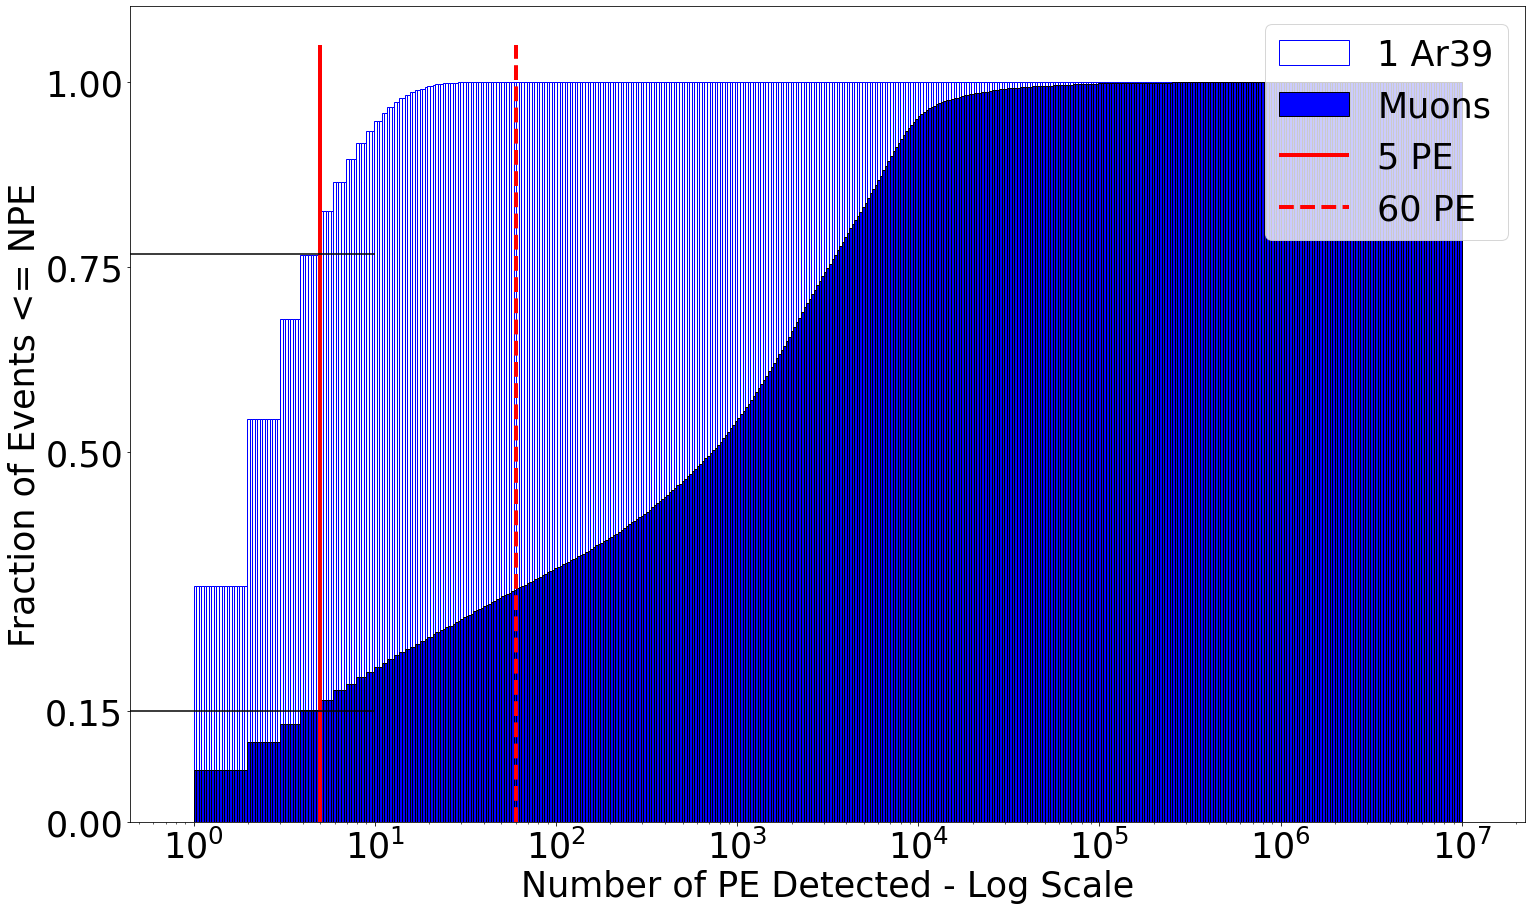

In [26]:
bins = np.logspace(0, 7, 500)
plt.hist(ar39_dfs[0].pedetected, bins=bins, density=True, cumulative=True, edgecolor='blue', color='w', label="1 Ar39")
plt.hist(df_mu.pedetected, bins=bins, density=True, cumulative=True, color='blue', label="Muons", edgecolor='k')
plt.vlines(5, 0, 1.05, color="red", label="5 PE", linewidth=4)
plt.vlines(60, 0, 1.05, color="red", label="60 PE", linewidth=4, linestyles='dashed')
plt.hlines(.15, 0, 10**1)
plt.hlines(.767, 0, 10**1)
plt.xscale("log")
plt.legend(loc="upper right")
plt.xlabel("Number of PE Detected - Log Scale")
plt.ylabel("Fraction of Events <= NPE")
plt.yticks([0, .15, .5, .75, 1])
plt.show()

In [42]:
# Remove test data for later eval
minPEcut, maxPEar39 = 5, 115
df_lear39_tmp = ar39_dfs[0]
df_lear39 = df_lear39_tmp[(df_lear39_tmp.pedetected >= minPEcut) & (df_lear39_tmp.pedetected <= maxPEar39)]
df_lemu = df_mu[(df_mu.pedetected >= minPEcut) & (df_mu.pedetected <= maxPEar39)]
print("[Info] Loaded {} Ar39 decays, with maximum {} PE detected".format(len(df_lear39), maxPEar39))
print("[Info] Selected {} Muons, with maximum {} PE detected".format(len(df_lemu), df_lemu.pedetected.max()))

n_test_mu, n_test_ar = 1000, 1000000
# split mu data
id_mu = np.arange(len(df_lemu))
np.random.shuffle(id_mu)
muons_test, muons_train = df_lemu.iloc[id_mu[:n_test_mu], :], df_lemu.iloc[id_mu[n_test_mu:], :]
# split ar39 data
id_ar = np.arange(len(df_lear39))
np.random.shuffle(id_ar)
ar39_test, ar39_train = df_lear39.iloc[id_ar[:n_test_ar], :], df_lear39.iloc[id_ar[n_test_ar:], :]
print("[Info] Muon Train {}, Test {}".format(len(muons_train), len(muons_test)))
print("[Info] Ar39 Train {}, Test {}".format(len(ar39_train), len(ar39_test)))

[Info] Loaded 1474688 Ar39 decays, with maximum 115 PE detected
[Info] Selected 6247 Muons, with maximum 115 PE detected
[Info] Muon Train 5247, Test 1000
[Info] Ar39 Train 474688, Test 1000000


In [43]:
# Prepare data
init = time.time()

init = time.time()
mu_test_feat = pd.DataFrame()
mu_test_feat["PEDetected_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
mu_test_feat["NActiveSlices_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
mu_test_feat["MeanNPEActive_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
mu_test_feat["SpatialRange_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
mu_test_feat["PEDetected_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
mu_test_feat["NActiveSlices_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
mu_test_feat["MeanNPEActive_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
mu_test_feat["SpatialRange_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
mu_test_feat["PEDetected_tot"] = mu_test_feat["PEDetected_inner"] + mu_test_feat["PEDetected_outer"]
mu_test_feat["NActiveSlices_tot"] = mu_test_feat["NActiveSlices_inner"] + mu_test_feat["NActiveSlices_outer"]
print("Compute Mu Combined features: {:.3f} sec".format(time.time() - init))

init = time.time()
ar_test_feat = pd.DataFrame()
ar_test_feat["PEDetected_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
ar_test_feat["NActiveSlices_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar_test_feat["MeanNPEActive_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
ar_test_feat["SpatialRange_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
print("Compute Ar features: {:.3f} sec".format(time.time() - init))
init = time.time()
ar_test_feat["PEDetected_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
ar_test_feat["NActiveSlices_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar_test_feat["MeanNPEActive_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
ar_test_feat["SpatialRange_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
print("Compute Ar features: {:.3f} sec".format(time.time() - init))
ar_test_feat["PEDetected_tot"] = ar_test_feat["PEDetected_inner"] + ar_test_feat["PEDetected_outer"]
ar_test_feat["NActiveSlices_tot"] = ar_test_feat["NActiveSlices_inner"] + ar_test_feat["NActiveSlices_outer"]
print("Compute Ar Combined features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 0.046 sec
Compute Mu Inner features: 0.048 sec
Compute Mu Combined features: 0.049 sec
Compute Ar features: 38.939 sec
Compute Ar features: 39.596 sec
Compute Ar Combined features: 39.603 sec


[Result] Test(1000 Mu, 1000000 Ar):
Accuracy: 0.880, Precision: 0.007, Recall: 0.885, F1: 0.015

[Result] Conf. Matrix: TN: 879941, FP: 120059, FN: 115, TP: 885 | TPR: 88.50%, FPR: 12.01%



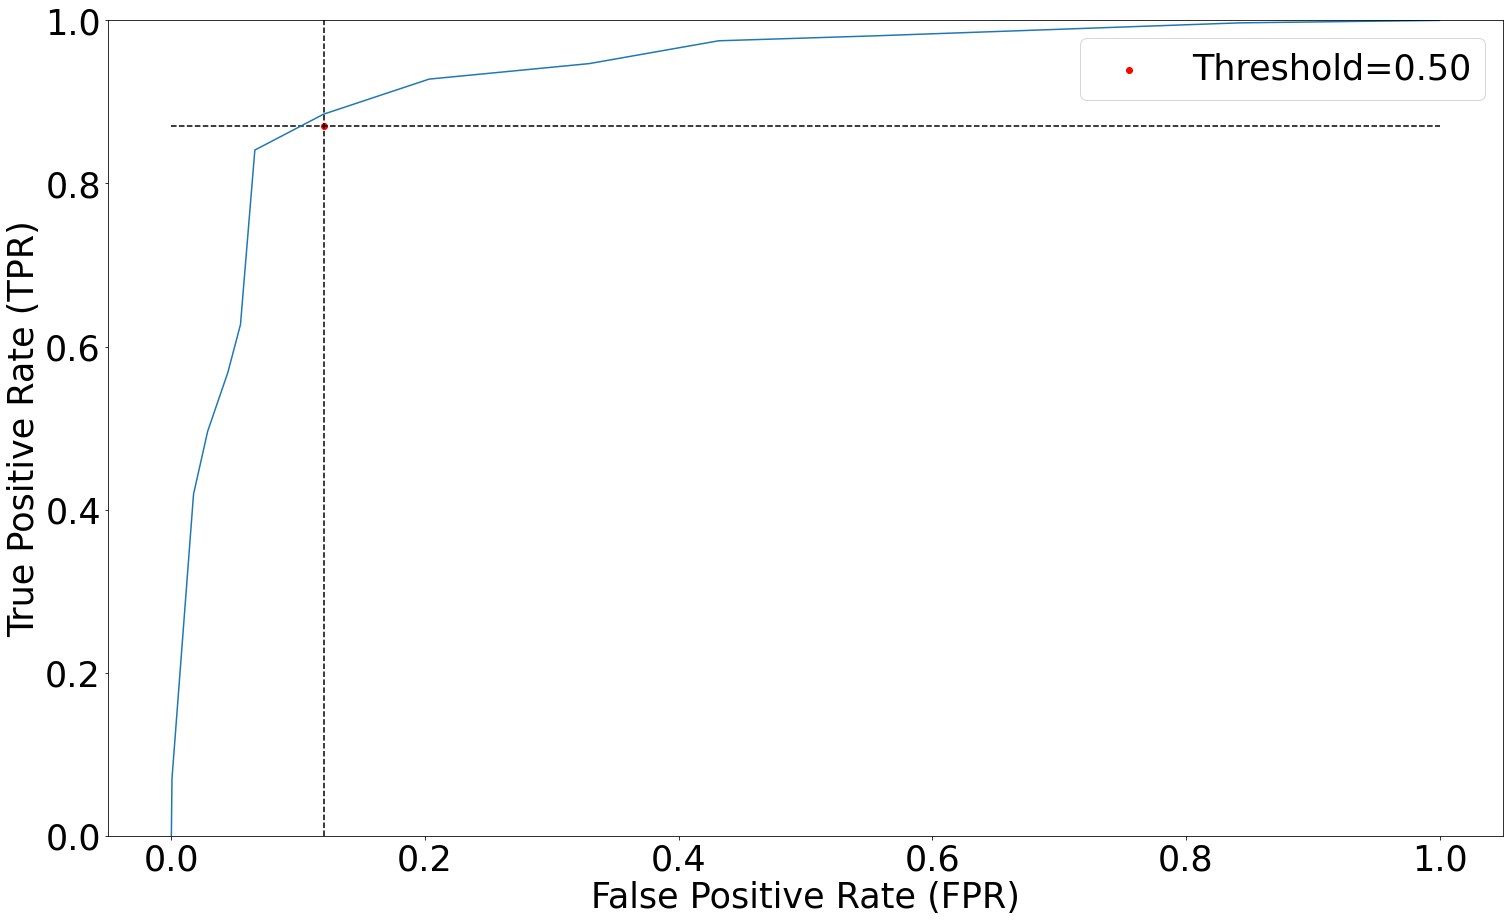

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cv
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score

mu_test_feat["y"] = 1
ar_test_feat["y"] = 0
test_data = pd.concat([mu_test_feat, ar_test_feat], axis=0)
X, y = test_data.iloc[:, :-1], test_data.iloc[:, -1]

y_pred_proba = clf.predict_proba(X)[:, 1]
y_pred = clf.predict(X)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
tn, fp, fn, tp = cv(y, y_pred).ravel()
tpr, fpr = recall*100, fp/(fp+tn)*100

result_template  = "[Result] {}:\nAccuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}\n"
cm_template  =     "[Result] Conf. Matrix: TN: {}, FP: {}, FN: {}, TP: {} | TPR: {:.2f}%, FPR: {:.2f}%\n"


print(result_template.format("Test({} Mu, {} Ar)".format(len(mu_test_feat), len(ar_test_feat)),
                             accuracy, precision, recall, f1))    
print(cm_template.format(tn, fp, fn, tp, tpr, fpr))    

fpr_dt, tpr_dt, thresholds = roc_curve(y, y_pred_proba)
auc = roc_auc_score(y, y_pred_proba)
plt.plot(fpr_dt, tpr_dt)
threshold_id = np.argmin(abs(thresholds-.50))
#plt.text(.5, .5, "AUC: {:.3f}".format(auc))
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
#plt.title("ROC Curve")
plt.scatter(0.12, 0.87, color='r', label="Threshold=0.50")
plt.vlines(0.12, 0, 1, linestyles='dashed')
plt.hlines(0.87, 0, 1, linestyles='dashed')
plt.ylim(0, 1)
plt.legend()
plt.show()

/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(1001000, 32, 1)
[Result] Test(1000 Mu, 1000000 Ar):
Accuracy: 0.874, Precision: 0.007, Recall: 0.830, F1: 0.013

[Result] Conf. Matrix: TN: 874472, FP: 125528, FN: 170, TP: 830 | TPR: 83.00%, FPR: 12.55%



No handles with labels found to put in legend.


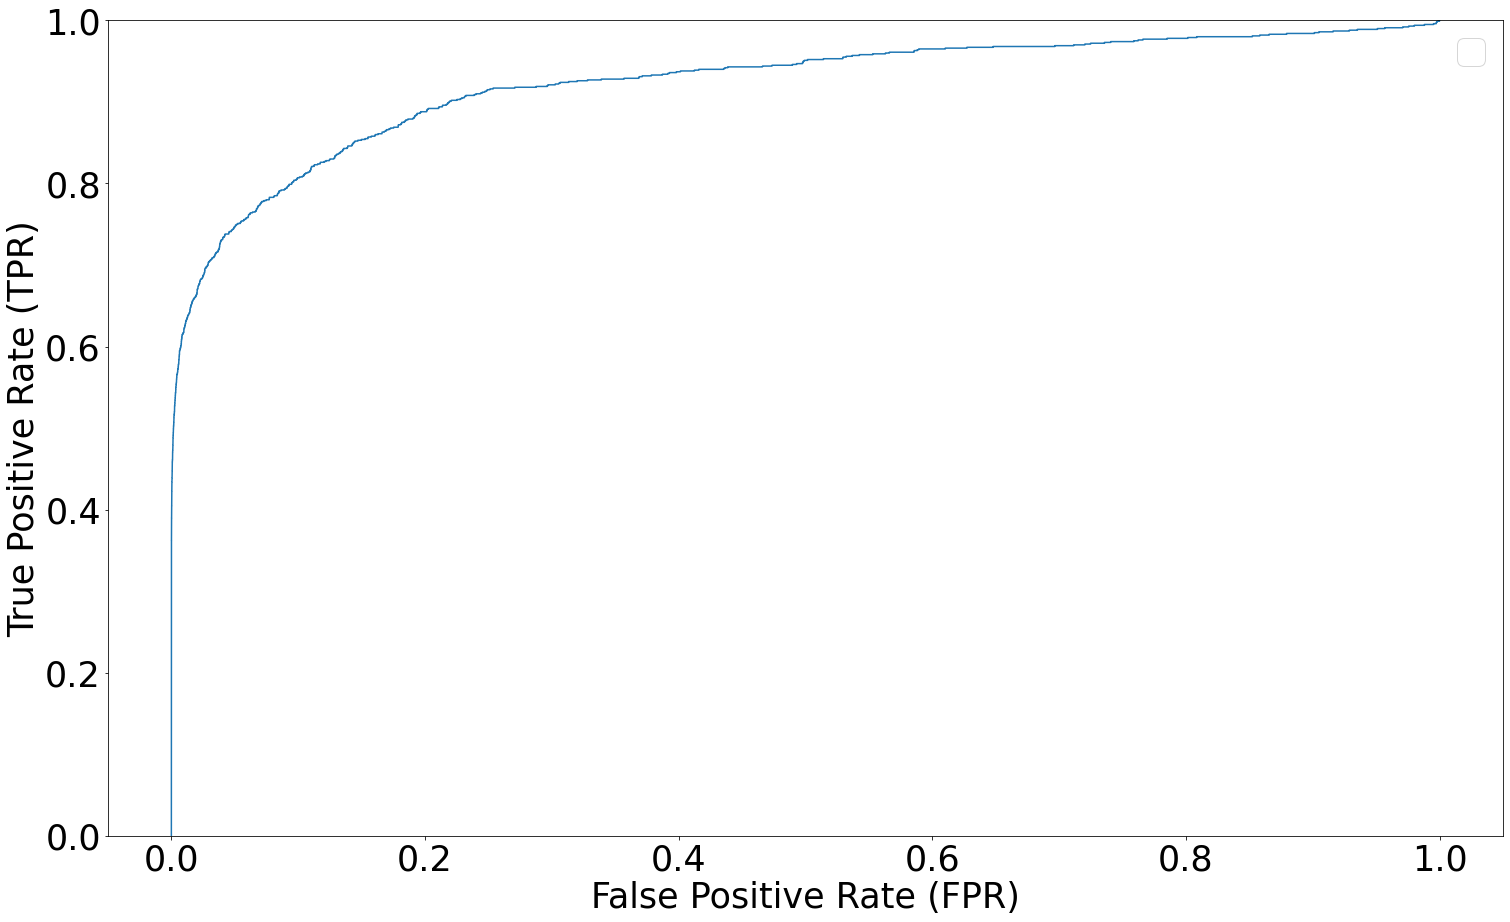

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cv
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score

muons_test["y"] = 1
ar39_test["y"] = 0
test_data = pd.concat([muons_test, ar39_test], axis=0)
Xraw, yraw = test_data.iloc[:, 3:3+n_inner_slices+n_outer_slices], test_data.iloc[:, -1]
Xraw = Xraw.to_numpy().reshape((Xraw.shape[0], Xraw.shape[1], 1))
print(Xraw.shape)
yraw_pred_proba = cnn_model.predict(Xraw)
yraw_pred_proba = yraw_pred_proba.reshape(yraw_pred_proba.shape[0])
yraw_pred = np.where(yraw_pred_proba>.5, 1, 0)
accuracy = accuracy_score(yraw, yraw_pred)
precision = precision_score(yraw, yraw_pred)
recall = recall_score(yraw, yraw_pred)
f1 = f1_score(yraw, yraw_pred)
tn, fp, fn, tp = cv(yraw, yraw_pred).ravel()
tpr, fpr = recall*100, fp/(fp+tn)*100

result_template  = "[Result] {}:\nAccuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}\n"
cm_template  =     "[Result] Conf. Matrix: TN: {}, FP: {}, FN: {}, TP: {} | TPR: {:.2f}%, FPR: {:.2f}%\n"


print(result_template.format("Test({} Mu, {} Ar)".format(len(mu_test_feat), len(ar_test_feat)),
                             accuracy, precision, recall, f1))    
print(cm_template.format(tn, fp, fn, tp, tpr, fpr))    

fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(yraw, yraw_pred_proba)
auc = roc_auc_score(yraw, yraw_pred)
plt.plot(fpr_cnn, tpr_cnn)
threshold_id = np.argmin(abs(thresholds-.50))
#plt.text(.5, .5, "AUC: {:.3f}".format(auc))
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
#plt.title("ROC Curve")
#plt.scatter(0.12, 0.87, color='r', label="Threshold=0.50")
#plt.vlines(0.12, 0, 1, linestyles='dashed')
#plt.hlines(0.87, 0, 1, linestyles='dashed')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [46]:
data = {"y":yraw, "y_dtree_pred":yraw_pred_proba, "y_cnn_pred":y_pred_proba}
df_mu_preds = pd.DataFrame(data)
df_mu_preds

,y,y_dtree_pred,y_cnn_pred
111,1,0.998829,0.983745
124,1,1.000000,0.759494
26,1,1.000000,0.759494
82,1,0.767215,0.885986
37,1,0.999970,0.759494
...,...,...,...
29960,0,0.124540,0.235529
26282,0,0.672013,0.544256
9919,0,0.101189,0.014120
10437,0,0.130938,0.014120


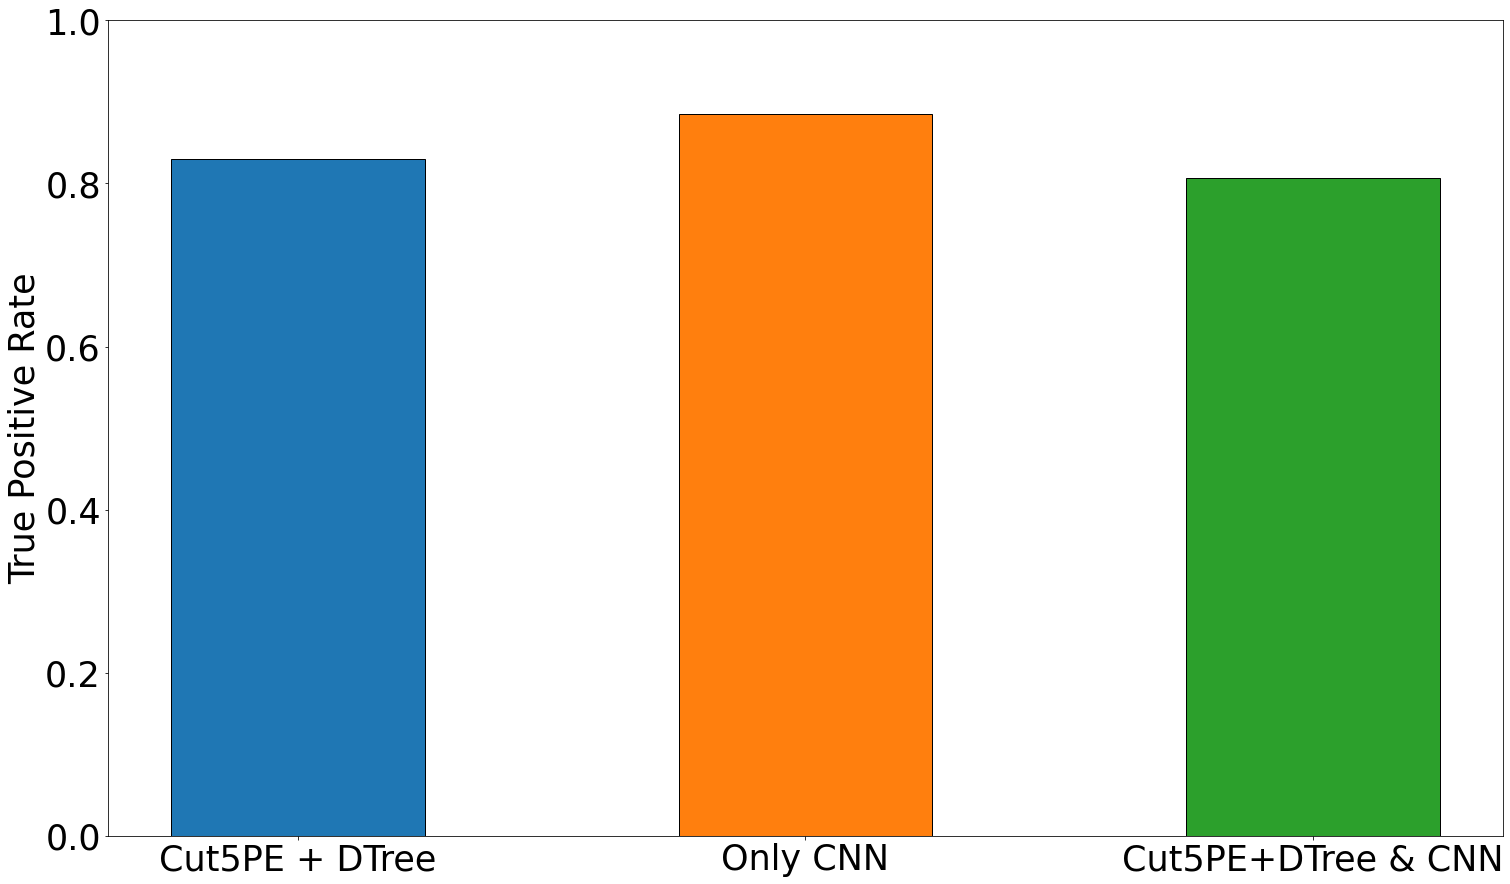

0.83
0.885
0.807


In [47]:
tpr_dtree = len(df_mu_preds[(df_mu_preds.y==1) & (df_mu_preds.y_dtree_pred>.5)]) / len(df_mu_preds[df_mu_preds.y==1])
tpr_cnn = len(df_mu_preds[(df_mu_preds.y==1) & (df_mu_preds.y_cnn_pred>.5)]) / len(df_mu_preds[df_mu_preds.y==1])
tpr_combo = len(df_mu_preds[(df_mu_preds.y==1) & (df_mu_preds.y_dtree_pred>.5) & (df_mu_preds.y_cnn_pred>.5)]) / len(df_mu_preds[df_mu_preds.y==1])
plt.bar(1, tpr_dtree, edgecolor='k', width=0.5)
plt.bar(2, tpr_cnn, edgecolor='k', width=.5)
plt.bar(3, tpr_combo, edgecolor='k', width=.5)
plt.xticks([1,2,3], ["Cut5PE + DTree", "Only CNN", "Cut5PE+DTree & CNN"])
plt.ylabel("True Positive Rate")
plt.ylim(0, 1)
plt.show()
print(tpr_dtree)
print(tpr_cnn)
print(tpr_combo)

In [150]:
combo_pred_proba = (y_pred_proba + yraw_pred_proba)
fpr_combo, tpr_combo, thresholds_combo = roc_curve(yraw, combo_pred_proba)

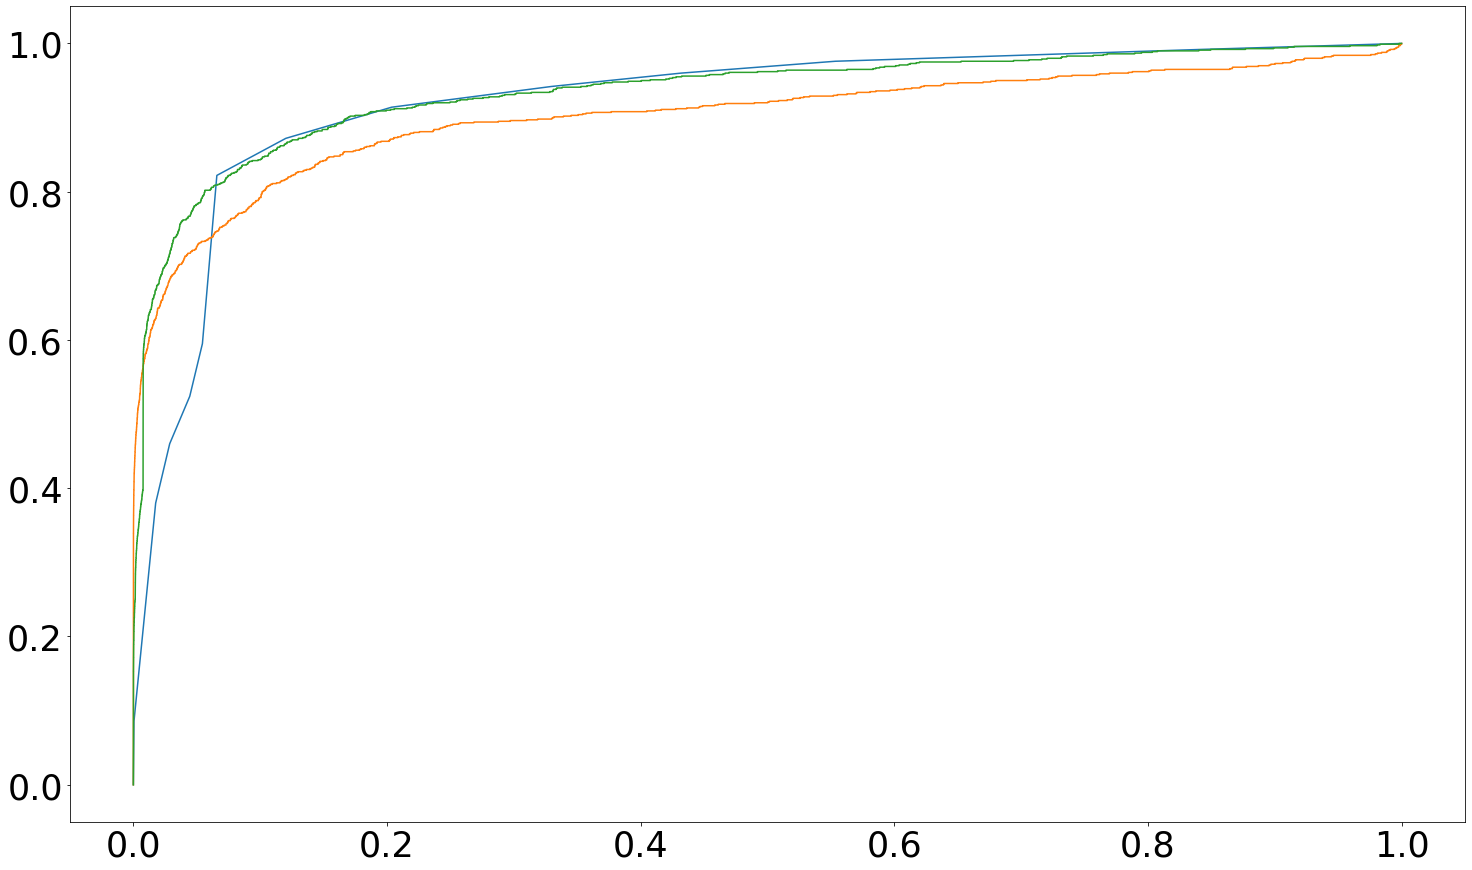

In [151]:
plt.plot(fpr_dt, tpr_dt)
plt.plot(fpr_cnn, tpr_cnn)
plt.plot(fpr_combo, tpr_combo)
plt.show()

In [27]:
fpr_dts, fpr_cnns, fpr_combos = [], [], []
for ar39_df in ar39_dfs:
    fpr_dtree = len(ar39_df[(ar39_df.y_dtree_pred>.5)]) / len(ar39_df)
    fpr_cnn = len(ar39_df[(ar39_df.y_cnn_pred>.5)]) / len(ar39_df)
    fpr_combo = len(ar39_df[(ar39_df.y_dtree_pred>.5) & (ar39_df.y_cnn_pred>.5)]) / len(ar39_df)
    fpr_dts.append(fpr_dtree)
    fpr_cnns.append(fpr_cnn)
    fpr_combos.append(fpr_combo)

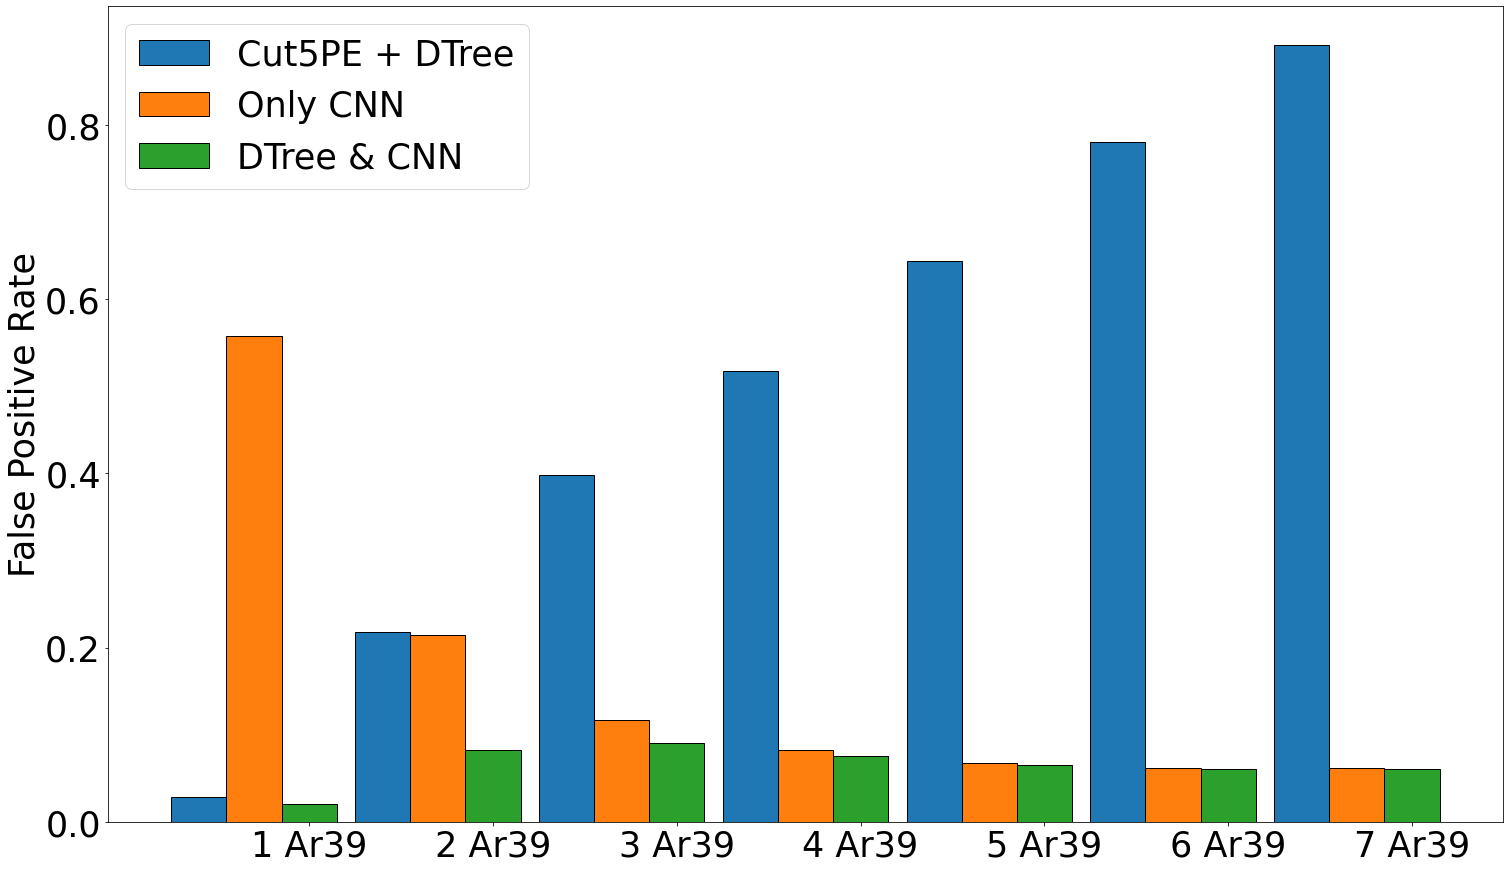

In [29]:
width=0.3
plt.bar(np.arange(len(fpr_dts)), fpr_dts, tick_label=ar39_dfs_names, label="Cut5PE + DTree", width=width, edgecolor='k')
plt.bar(np.arange(len(fpr_cnns)) + width, fpr_cnns, tick_label=ar39_dfs_names, label="Only CNN", width=width, edgecolor='k')
plt.bar(np.arange(len(fpr_combos)) + 2*width, fpr_combos, tick_label=ar39_dfs_names, label="DTree & CNN", width=width, edgecolor='k')
plt.legend()
plt.ylabel("False Positive Rate")
plt.show()

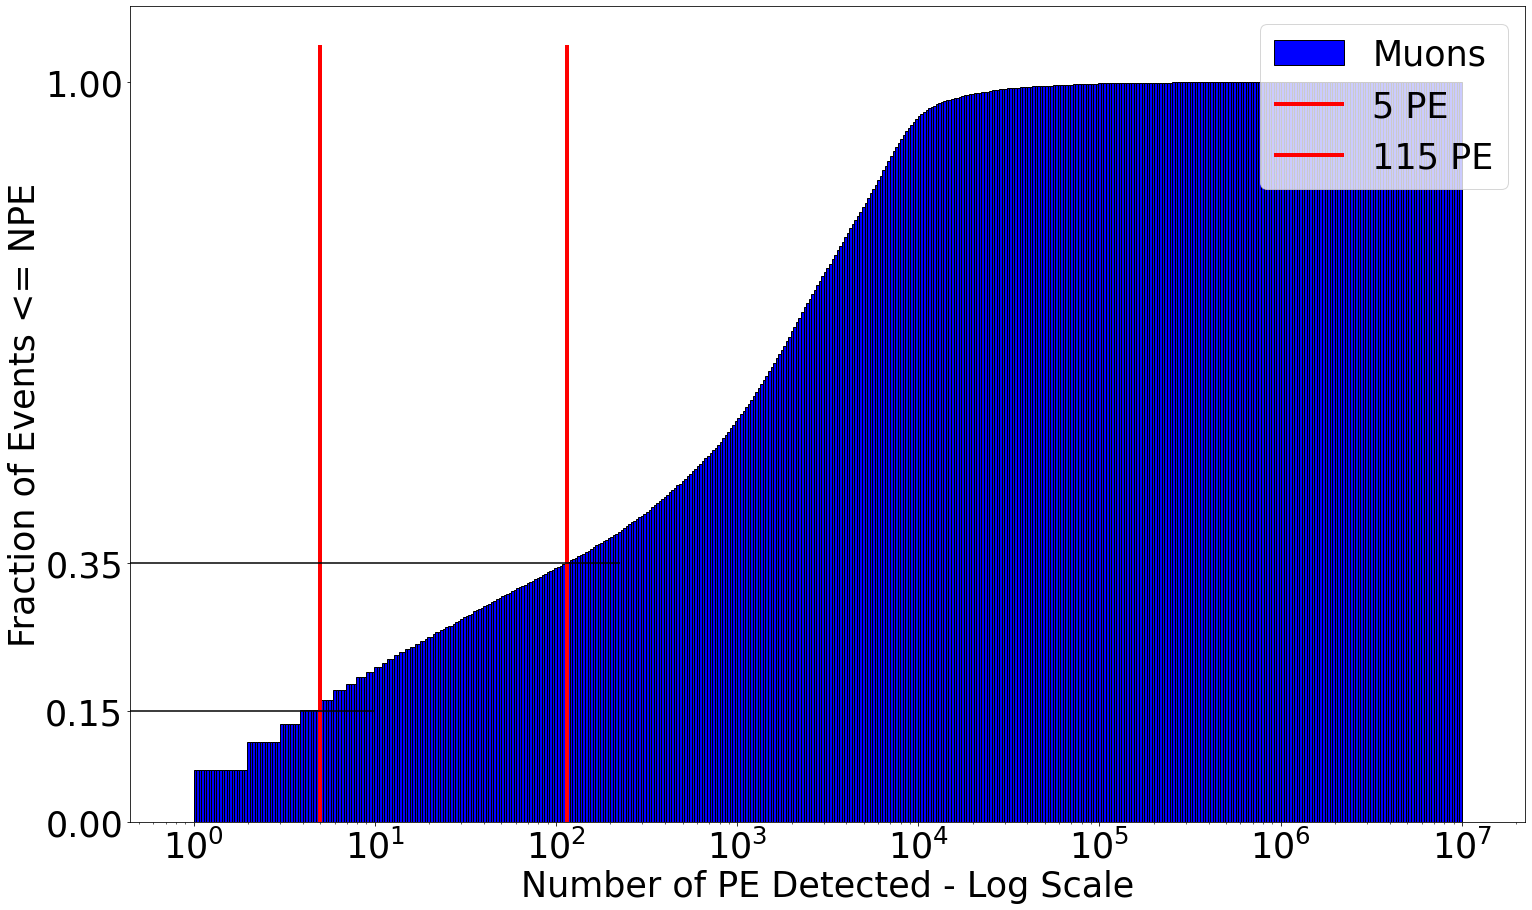

In [49]:
bins = np.logspace(0, 7, 500)
plt.hist(df_mu.pedetected, bins=bins, density=True, cumulative=True, color='blue', label="Muons", edgecolor='k')
plt.vlines(5, 0, 1.05, color="red", label="5 PE", linewidth=4)
plt.vlines(115, 0, 1.05, color="red", label="115 PE", linewidth=4, linestyles='solid')
plt.hlines(.15, 0, 10**1)
plt.hlines(.35, 0, 15**2)
plt.xscale("log")
plt.legend(loc="upper right")
plt.xlabel("Number of PE Detected - Log Scale")
plt.ylabel("Fraction of Events <= NPE")
plt.yticks([0, .15, .35, 1])
plt.show()